[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Loading data...
Preprocessed data: kept 4937 samples from 4937
Preprocessed data: kept 2189 samples from 2189
Successfully loaded data from CSV files: 4937 training samples, 2189 test samples

Running TF classification...

--- Term Frequency Features ---
tf_KNN                  Accuracy: 87.53, Precision: 87.74, Recall: 87.53
tf_SVM                  Accuracy: 96.48, Precision: 96.56, Recall: 96.48
tf_LogisticRegression   Accuracy: 96.21, Precision: 96.16, Recall: 96.21
tf_DecisionTree         Accuracy: 91.00, Precision: 90.80, Recall: 91.00
tf_RandomForest         Accuracy: 92.78, Precision: 93.10, Recall: 92.78
tf_NaiveBayes           Accuracy: 95.84, Precision: 96.28, Recall: 95.84
tf_VotingClassifier     Accuracy: 97.26, Precision: 97.25, Recall: 97.26
tf_StackingClassifier   Accuracy: 97.03, Precision: 97.02, Recall: 97.03

Running TF-IDF classification...

--- TF-IDF Features ---
tf_idf_KNN                  Accuracy: 82.91, Precision: 83.97, Recall: 82.91
tf_idf_SVM               

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(



Training LDA model with 20 topics...
Time taken: 69.54 seconds
Transforming documents to topic space...

--- LDA topics Classification Results ---
LDA_topics_KNN                  Accuracy: 91.50, Precision: 91.50, Recall: 91.50
LDA_topics_SVM                  Accuracy: 91.96, Precision: 91.85, Recall: 91.96
LDA_topics_LogisticRegression   Accuracy: 92.78, Precision: 92.43, Recall: 92.78
LDA_topics_DecisionTree         Accuracy: 88.72, Precision: 88.96, Recall: 88.72
LDA_topics_RandomForest         Accuracy: 93.60, Precision: 93.79, Recall: 93.60
LDA_topics_NaiveBayes           Accuracy: 82.69, Precision: 77.31, Recall: 82.69
LDA_topics_VotingClassifier     Accuracy: 91.55, Precision: 90.75, Recall: 91.55
Saved model: /kaggle/working/models/LDA_topics_20_VotingClassifier.joblib
LDA_topics_StackingClassifier   Accuracy: 92.28, Precision: 92.47, Recall: 92.28
LDA_topics_StackingClassifier    ERROR: name 'KODEL_DIR' is not defined
Transforming documents based on word-topic distributions..

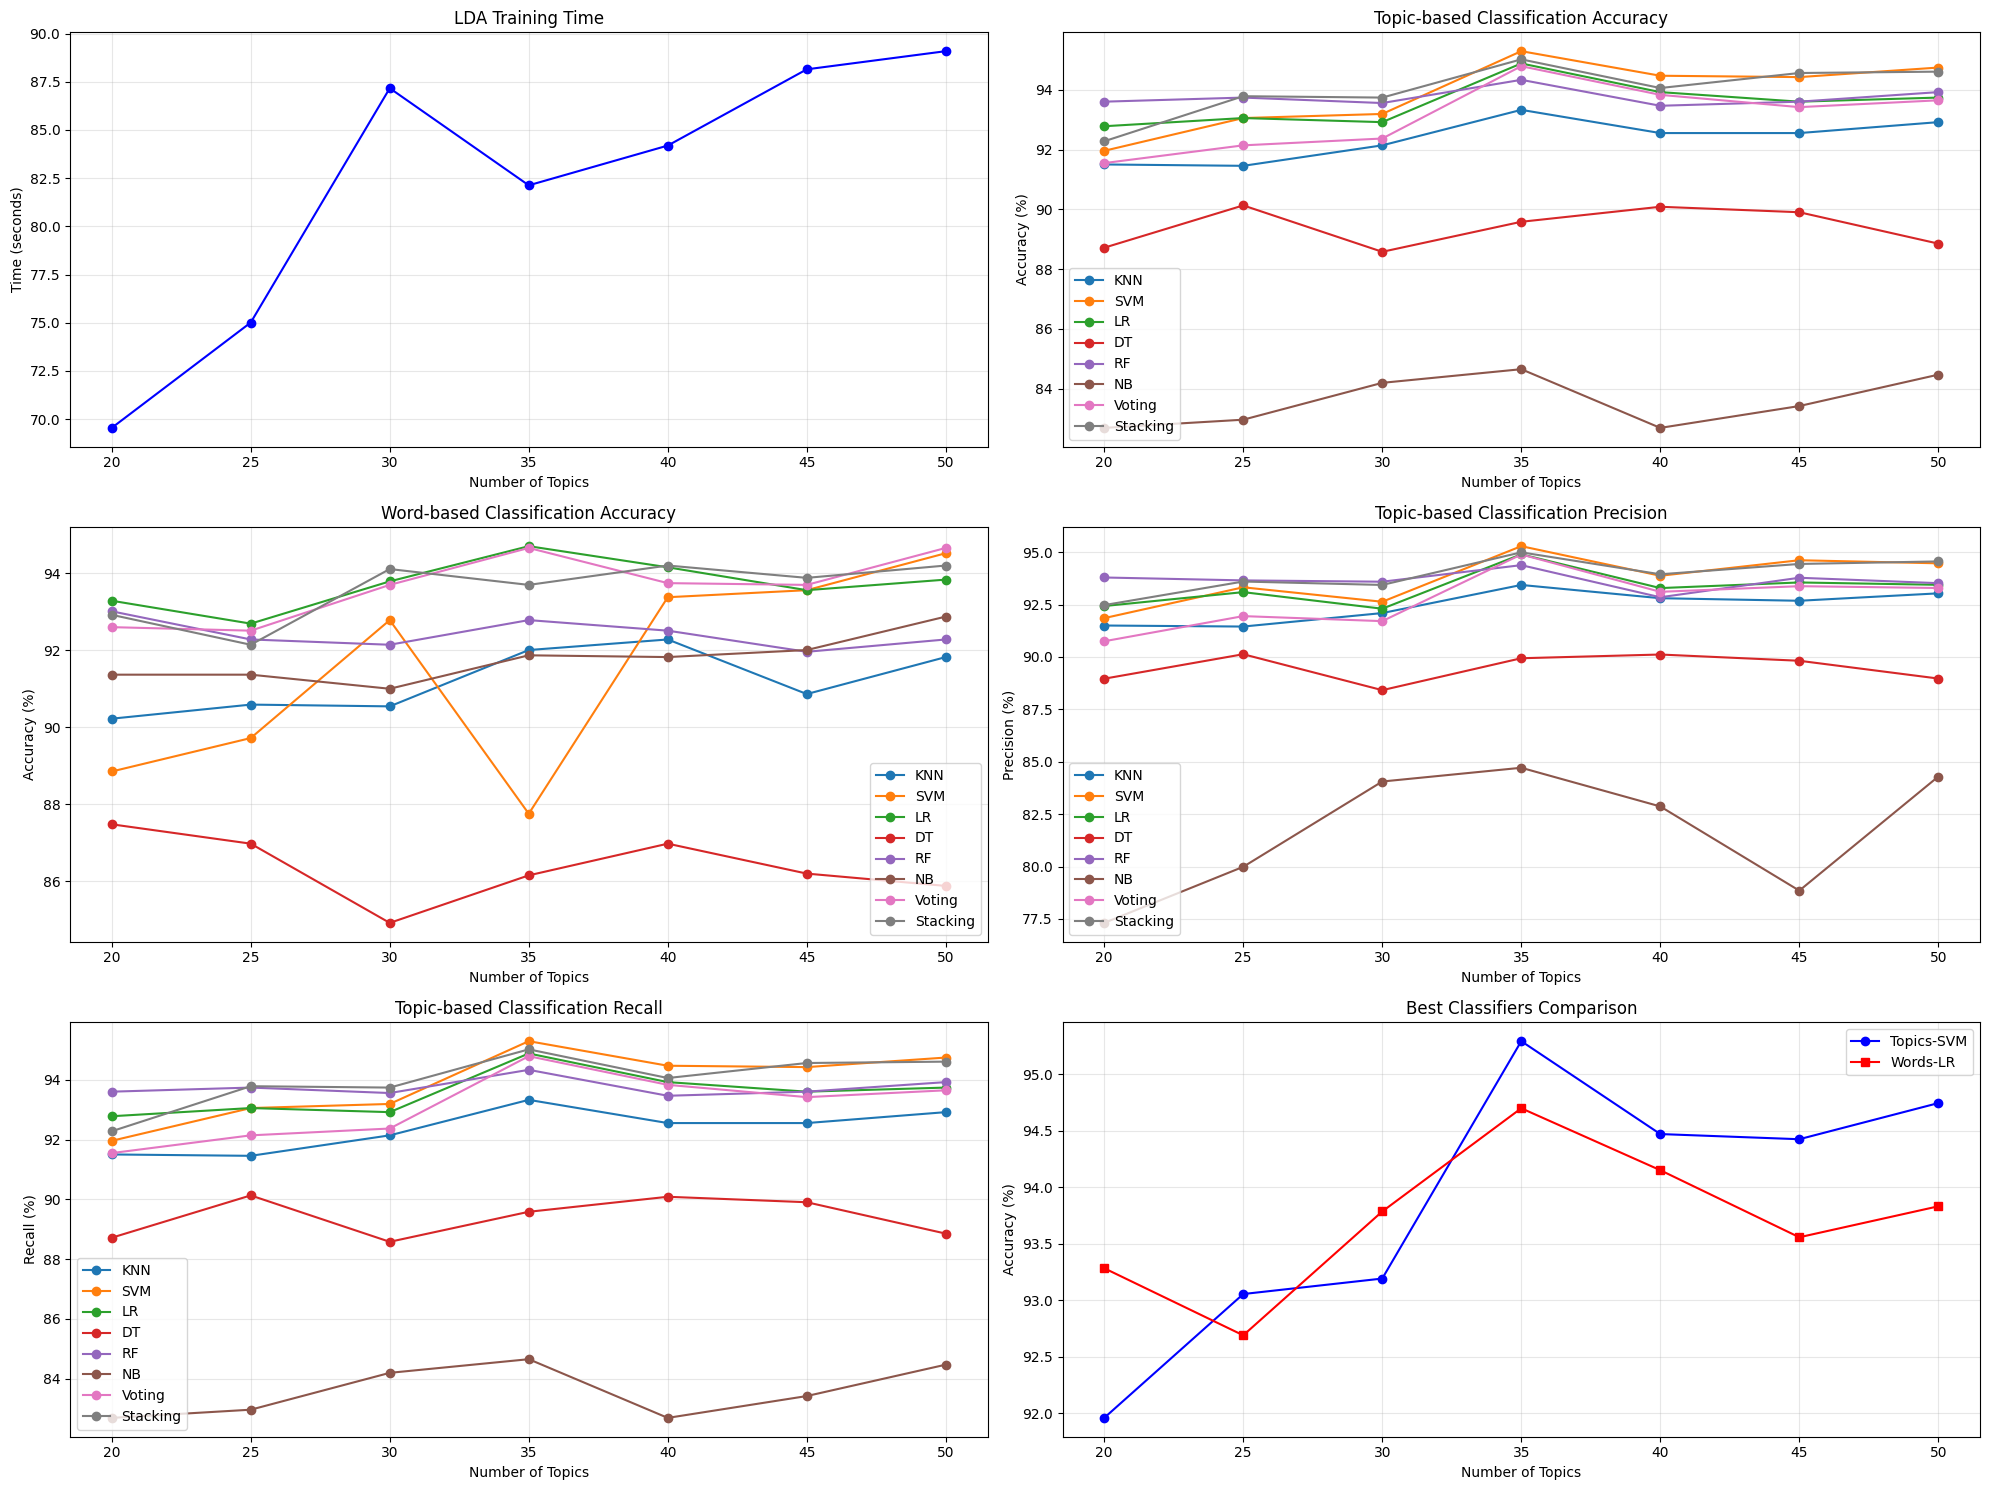

In [1]:
# Import libraries
import nltk
import numpy as np
import matplotlib.pyplot as plt
import timeit
import warnings
import os
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from sklearn.datasets import fetch_20newsgroups
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
import joblib  # For model saving

# Download NLTK data
nltk.download('stopwords')

# Create directory for saving models in Kaggle's writable directory
MODEL_DIR = "/kaggle/working/models"
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

# Initialize NLTK components
tokenizer = RegexpTokenizer(r'\w+')
p_stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def preprocess_data(texts, labels):
    """Preprocess text data and labels, handling NaN and invalid entries"""
    processed_texts = []
    processed_labels = []
    
    for text, label in zip(texts, labels):
        # Skip if text or label is NaN or invalid
        if pd.isna(text) or pd.isna(label) or not isinstance(text, str):
            continue
            
        # Remove excessive whitespace and clean text
        text = ' '.join(text.strip().split())
        
        # Remove special characters and numbers (optional, can be customized)
        text = ''.join(char for char in text if char.isalpha() or char.isspace())
        
        # Skip empty texts after cleaning
        if len(text.strip()) == 0:
            continue
            
        processed_texts.append(text)
        processed_labels.append(label)
    
    print(f"Preprocessed data: kept {len(processed_texts)} samples from {len(texts)}")
    return processed_texts, np.array(processed_labels)

def load_data_csv(path, text_column='text', label_column='intent'):
    """Load and preprocess data from CSV file"""
    try:
        df = pd.read_csv(path)
        # Check if the required columns exist
        if text_column not in df.columns or label_column not in df.columns:
            raise ValueError(f"CSV file must contain '{text_column}' and '{label_column}' columns")
        
        # Handle missing values in the dataframe
        df = df[[text_column, label_column]].dropna()
        
        X = df[text_column].tolist()
        y = np.array(df[label_column])
        
        # Apply preprocessing
        X, y = preprocess_data(X, y)
        
        return X, y
    except Exception as e:
        print(f"Error loading CSV file: {str(e)}")
        return [], np.array([])

def tokenize(doc_set):
    """Tokenize, remove stopwords and stem documents"""
    texts = []
    for doc in doc_set:
        if isinstance(doc, str):  # Make sure the document is a string
            # clean and tokenize document string
            raw = doc.lower()
            tokens = tokenizer.tokenize(raw)
            # remove stop words from tokens
            stopped_tokens = [i for i in tokens if not i in stop_words]
            # stem tokens
            stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
            # add tokens to list
            texts.append(' '.join(stemmed_tokens))
        else:
            texts.append('')  # Add empty string for non-string documents
    return texts

def tokenize_and_stem(text):
    """Tokenize, remove stopwords and stem text"""
    if not isinstance(text, str):
        return []
    # Remove stopwords and stemming
    tokens = tokenizer.tokenize(text.lower())
    stopped_tokens = [i for i in tokens if i not in stop_words]
    stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
    return stemmed_tokens

def evaluate_classifier(classifier, X_train, y_train, X_test, y_test, feature_name="", clf_name=""):
    """Train and evaluate classifier with accuracy, precision, and recall"""
    classifier.fit(X_train, y_train)
    predictions = classifier.predict(X_test)
    
    # Calculate metrics
    accuracy = 100 * accuracy_score(y_test, predictions)
    
    # For multiclass, calculate precision and recall with weighted average
    precision = 100 * precision_score(y_test, predictions, average='weighted', zero_division=0)
    recall = 100 * recall_score(y_test, predictions, average='weighted', zero_division=0)
    
    print(f"{feature_name}_{clf_name:<20} Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}")
    
    return accuracy, precision, recall

def run_classifiers(train_docs, train_labels, test_docs, test_labels, feature_name="", save_models=False, topic_num=None):
    """Run multiple classifiers, return metrics, and optionally save ensemble models"""
    results = {}
    
    # KNN Classifier
    knn_clf = KNeighborsClassifier(n_neighbors=1)
    knn_acc, knn_prec, knn_rec = evaluate_classifier(
        knn_clf, train_docs, train_labels, test_docs, test_labels, feature_name, "KNN")
    results['KNN'] = {'acc': knn_acc, 'prec': knn_prec, 'rec': knn_rec}
    
    # SVM Classifier
    svm_clf = SGDClassifier(random_state=42, max_iter=1000, tol=.001)
    svm_acc, svm_prec, svm_rec = evaluate_classifier(
        svm_clf, train_docs, train_labels, test_docs, test_labels, feature_name, "SVM")
    results['SVM'] = {'acc': svm_acc, 'prec': svm_prec, 'rec': svm_rec}
    
    # Logistic Regression
    lr_clf = LogisticRegression(max_iter=1000, random_state=42)
    lr_acc, lr_prec, lr_rec = evaluate_classifier(
        lr_clf, train_docs, train_labels, test_docs, test_labels, feature_name, "LogisticRegression")
    results['LR'] = {'acc': lr_acc, 'prec': lr_prec, 'rec': lr_rec}
    
    # Decision Tree
    dt_clf = DecisionTreeClassifier(random_state=42)
    dt_acc, dt_prec, dt_rec = evaluate_classifier(
        dt_clf, train_docs, train_labels, test_docs, test_labels, feature_name, "DecisionTree")
    results['DT'] = {'acc': dt_acc, 'prec': dt_prec, 'rec': dt_rec}
    
    # Random Forest
    rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_acc, rf_prec, rf_rec = evaluate_classifier(
        rf_clf, train_docs, train_labels, test_docs, test_labels, feature_name, "RandomForest")
    results['RF'] = {'acc': rf_acc, 'prec': rf_prec, 'rec': rf_rec}
    
    # Naive Bayes (only if data isn't negative)
    nb_acc, nb_prec, nb_rec = None, None, None
    try:
        # Check for negative values
        if hasattr(train_docs, 'toarray'):
            has_negative = (train_docs.toarray() < 0).any() or (test_docs.toarray() < 0).any()
        else:
            has_negative = (train_docs < 0).any() or (test_docs < 0).any()

        if has_negative:
            # Data contains negative values, use min-max scaling
            from sklearn.preprocessing import MinMaxScaler
            scaler = MinMaxScaler()

            # Handle sparse matrices appropriately
            if hasattr(train_docs, 'toarray'):
                train_docs_scaled = scaler.fit_transform(train_docs.toarray())
                test_docs_scaled = scaler.transform(test_docs.toarray())
            else:
                train_docs_scaled = scaler.fit_transform(train_docs)
                test_docs_scaled = scaler.transform(test_docs)

            nb_clf = MultinomialNB()
            nb_acc, nb_prec, nb_rec = evaluate_classifier(
                nb_clf, train_docs_scaled, train_labels, test_docs_scaled, test_labels, 
                feature_name, "NaiveBayes_scaled")
        else:
            # Data doesn't contain negative values, use as is
            nb_clf = MultinomialNB()
            nb_acc, nb_prec, nb_rec = evaluate_classifier(
                nb_clf, train_docs, train_labels, test_docs, test_labels, 
                feature_name, "NaiveBayes")
    except Exception as e:
        print(f"{feature_name}_NaiveBayes    ERROR: {str(e)}")
    
    if nb_acc is not None:
        results['NB'] = {'acc': nb_acc, 'prec': nb_prec, 'rec': nb_rec}
    
    # Voting Classifier (ensemble)
    try:
        # Create base classifiers
        lr = LogisticRegression(max_iter=1000, random_state=42)
        nb = MultinomialNB()
        svm = SGDClassifier(random_state=42, max_iter=1000, tol=.001)
        
        # Create voting classifier
        voting_clf = VotingClassifier(
            estimators=[('lr', lr), ('svm', svm), ('nb', nb)],
            voting='hard'  # Use hard voting (majority rule)
        )
        
        voting_acc, voting_prec, voting_rec = evaluate_classifier(
            voting_clf, train_docs, train_labels, test_docs, test_labels, 
            feature_name, "VotingClassifier")
        
        results['Voting'] = {'acc': voting_acc, 'prec': voting_prec, 'rec': voting_rec}
        
        # Save VotingClassifier if save_models is True
        if save_models:
            prefix = f"{feature_name}_VotingClassifier"
            if topic_num is not None:
                prefix = f"{feature_name}_{topic_num}_VotingClassifier"
            model_path = os.path.join(MODEL_DIR, f"{prefix}.joblib")
            joblib.dump(voting_clf, model_path)
            print(f"Saved model: {model_path}")
    except Exception as e:
        print(f"{feature_name}_VotingClassifier    ERROR: {str(e)}")
    
    # Stacking Classifier (ensemble)
    try:
        # Create base classifiers
        estimators = [
            ('lr', LogisticRegression(max_iter=1000, random_state=42)),
            ('nb', MultinomialNB()),
            ('svm', SGDClassifier(random_state=42, max_iter=1000, tol=.001))
        ]
        
        # Final estimator
        final_estimator = RandomForestClassifier(n_estimators=10, random_state=42)
        
        # Create stacking classifier
        stacking_clf = StackingClassifier(
            estimators=estimators,
            final_estimator=final_estimator,
            cv=5  # 5-fold cross-validation
        )
        
        stacking_acc, stacking_prec, stacking_rec = evaluate_classifier(
            stacking_clf, train_docs, train_labels, test_docs, test_labels, 
            feature_name, "StackingClassifier")
        
        results['Stacking'] = {'acc': stacking_acc, 'prec': stacking_prec, 'rec': stacking_rec}
        
        # Save StackingClassifier if save_models is True
        if save_models:
            prefix = f"{feature_name}_StackingClassifier"
            if topic_num is not None:
                prefix = f"{feature_name}_{topic_num}_StackingClassifier"
            model_path = os.path.join(KODEL_DIR, f"{prefix}.joblib")
            joblib.dump(stacking_clf, model_path)
            print(f"Saved model: {model_path}")
    except Exception as e:
        print(f"{feature_name}_StackingClassifier    ERROR: {str(e)}")
    
    return results

def tf_classify(train_docs, train_labels, test_docs, test_labels):
    """Classify using term frequency features"""
    print("\n--- Term Frequency Features ---")

    # Create vectorizer
    count_vect = CountVectorizer()
    X_train_counts = count_vect.fit_transform(train_docs)
    X_test_counts = count_vect.transform(test_docs)

    # Run all classifiers
    results = run_classifiers(X_train_counts, train_labels, X_test_counts, test_labels, "tf")
    return results

def tf_idf_classify(train_docs, train_labels, test_docs, test_labels):
    """Classify using TF-IDF features"""
    print("\n--- TF-IDF Features ---")

    # Create vectorizer
    tfidf_vect = TfidfVectorizer()
    X_train_tfidf = tfidf_vect.fit_transform(train_docs)
    X_test_tfidf = tfidf_vect.transform(test_docs)

    # Run all classifiers and save ensemble models
    results = run_classifiers(X_train_tfidf, train_labels, X_test_tfidf, test_labels, "tf_idf", save_models=True)
    return results

def load_glove_data():
    """Load GloVe embeddings"""
    # Check if file already exists
    GLOVE_PATH = "/kaggle/working/glove.6B.100d.txt"

    if not os.path.exists(GLOVE_PATH):
        print("Downloading GloVe embeddings...")
        # Try direct download from Stanford
        try:
            import urllib.request
            urllib.request.urlretrieve("http://nlp.stanford.edu/data/glove.6B.zip", "/kaggle/working/glove.6B.zip")
        except:
            print("Direct download failed. Using alternative source...")
            # Use alternative source if Stanford source is unavailable
            try:
                urllib.request.urlretrieve("https://huggingface.co/stanfordnlp/glove/resolve/main/glove.6B.zip", "/kaggle/working/glove.6B.zip")
            except:
                print("Failed to download from alternative source. Using random embeddings.")
                return create_random_embeddings()

        # Unzip the file
        print("Extracting GloVe embeddings...")
        import zipfile
        with zipfile.ZipFile("/kaggle/working/glove.6B.zip", 'r') as zip_ref:
            zip_ref.extract("glove.6B.100d.txt", "/kaggle/working/")

    # Read the word to vec file
    print("Loading word embeddings...")
    glove_dict = {}

    try:
        with open(GLOVE_PATH, "r", encoding="utf-8") as infile:
            for line in infile:
                parts = line.split()
                try:
                    word = parts[0]
                    vector = np.array([float(val) for val in parts[1:]])
                    glove_dict[word] = vector
                except:
                    pass
        print(f"Loaded {len(glove_dict)} word vectors")
        return glove_dict
    except FileNotFoundError:
        print("ERROR: GloVe file not found. Using random embeddings instead.")
        return create_random_embeddings()

def create_random_embeddings():
    """Create random word embeddings as fallback"""
    import random
    random.seed(42)
    dim = 100
    glove_dict = {}
    
    # Create a small random embedding dictionary for key words as fallback
    vocab = ["the", "a", "and", "of", "to", "in", "that", "is", "was", "for",
            "on", "with", "by", "as", "at", "from", "but", "not", "or", "an"]

    for word in vocab:
        glove_dict[word] = np.array([random.uniform(-1, 1) for _ in range(dim)])
    
    return glove_dict

def word2vec_transform(dataset, word2vec, dim):
    """Transform documents to word embeddings"""
    trans_data = []
    for doc in dataset:
        if not isinstance(doc, str):
            # Handle non-string input
            trans_data.append(np.zeros(dim))
            continue
            
        words = doc.lower().split()
        w_length = 1
        data = np.zeros(dim)
        for word in words:
            if word in word2vec and word not in stop_words:
                data = data + word2vec[word]
                w_length = w_length + 1
        data = data / float(w_length)
        trans_data.append(data)
    return np.array(trans_data)

def word2vec_classify(train_docs, train_labels, test_docs, test_labels):
    """Classify using word embeddings"""
    print("\n--- Word2Vec Features ---")

    word2vec = load_glove_data()
    train_docs_vec = word2vec_transform(train_docs, word2vec, 100)
    test_docs_vec = word2vec_transform(test_docs, word2vec, 100)

    # Run all classifiers and save ensemble models
    results = run_classifiers(train_docs_vec, train_labels, test_docs_vec, test_labels, "word2vec", save_models=True)
    return results

def create_vectorizer(doc_set):
    """Create a CountVectorizer with custom tokenization"""
    # Create vectorizer to convert text to term frequency matrix
    vectorizer = CountVectorizer(
        tokenizer=tokenize_and_stem,
        min_df=10,
        max_df=0.5
    )

    # Fit vectorizer on dataset
    vectorizer.fit(doc_set)
    return vectorizer

def lda_transform(vectorizer, ld_model, docs):
    """Transform documents to topic distributions using LDA"""
    X = vectorizer.transform(docs)
    return ld_model.transform(X)

def word_transform_sklearn(vectorizer, ld_model, docs, no_topics):
    """Transform documents based on word-topic distributions"""
    data = []
    for doc in docs:
        if not isinstance(doc, str):
            # Handle non-string input
            data.append(np.zeros(no_topics))
            continue
            
        # Process each word in document
        doc = ' '.join([word for word in doc.split() if word not in stop_words])
        doc = doc.lower()
        words = doc.split()

        doc_prob = np.zeros(no_topics)
        for word in words:
            if word in stop_words:
                continue
            # Transform single word to get topic distribution
            word_vec = vectorizer.transform([word])
            word_topic_dist = ld_model.transform(word_vec)
            doc_prob += word_topic_dist[0]

        data.append(doc_prob)
    return np.array(data)

def LDA_classify(train_docs, train_labels, test_docs, test_labels, feature_type="", topic_num=None):
    """Get classification metrics and save ensemble models"""
    print(f"\n--- LDA {feature_type} Classification Results ---")
    return run_classifiers(train_docs, train_labels, test_docs, test_labels, f"LDA_{feature_type}", save_models=True, topic_num=topic_num)

def run_basic_classifiers(train_data, train_labels, test_data, test_labels):
    """Run basic classifiers (TF, TF-IDF, Word2Vec)"""
    # TF classification
    print("\nRunning TF classification...")
    tf_results = tf_classify(train_data, train_labels, test_data, test_labels)
    
    # TF-IDF classification
    print("\nRunning TF-IDF classification...")
    tfidf_results = tf_idf_classify(train_data, train_labels, test_data, test_labels)
    
    # Word2Vec classification
    print("\nRunning Word2Vec classification...")
    w2v_results = word2vec_classify(train_data, train_labels, test_data, test_labels)
    
    return {
        'tf': tf_results,
        'tfidf': tfidf_results,
        'w2v': w2v_results
    }

def run_lda_classifiers(train_data, train_labels, test_data, test_labels):
    """Run LDA-based classifiers with different numbers of topics"""
    # LDA classification with different numbers of topics
    print("\nRunning LDA classification...")
    no_topics = [20, 25, 30, 35, 40, 45, 50]
    all_docs = train_data + test_data

    # Create vectorizer for all data
    vectorizer = create_vectorizer(all_docs)

    # Convert data to term frequency matrix
    corpus_vectors = vectorizer.transform(all_docs)

    time_taken = np.zeros(len(no_topics))
    
    # Initialize dictionaries to store results
    results_topics = {}
    results_words = {}
    
    # Initialize metrics dictionaries for each classifier
    for clf_name in ['KNN', 'SVM', 'LR', 'DT', 'RF', 'NB', 'Voting', 'Stacking']:
        results_topics[clf_name] = {
            'acc': np.zeros(len(no_topics)),
            'prec': np.zeros(len(no_topics)),
            'rec': np.zeros(len(no_topics))
        }
        results_words[clf_name] = {
            'acc': np.zeros(len(no_topics)),
            'prec': np.zeros(len(no_topics)),
            'rec': np.zeros(len(no_topics))
        }

    for i, n_topics in enumerate(no_topics):
        print(f"\nTraining LDA model with {n_topics} topics...")

        # Train LDA model
        start = timeit.default_timer()

        lda_model = LDA(
            n_components=n_topics,
            max_iter=50,
            learning_method='online',
            random_state=42,
            n_jobs=1,
            batch_size=128)

        # Fit LDA model
        lda_model.fit(corpus_vectors)

        end = timeit.default_timer()
        time_taken[i] = end - start
        print(f"Time taken: {time_taken[i]:.2f} seconds")

        # Document-topic classification
        print("Transforming documents to topic space...")
        train_docs_topics = lda_transform(vectorizer, lda_model, train_data)
        test_docs_topics = lda_transform(vectorizer, lda_model, test_data)

        topic_results = LDA_classify(
            train_docs_topics, train_labels, test_docs_topics, test_labels, "topics", topic_num=n_topics)

        for clf_name, metrics in topic_results.items():
            results_topics[clf_name]['acc'][i] = metrics['acc']
            results_topics[clf_name]['prec'][i] = metrics['prec']
            results_topics[clf_name]['rec'][i] = metrics['rec']

        # Word-topic classification
        print("Transforming documents based on word-topic distributions...")
        train_docs_words = word_transform_sklearn(
            vectorizer, lda_model, train_data, n_topics)
        test_docs_words = word_transform_sklearn(
            vectorizer, lda_model, test_data, n_topics)

        word_results = LDA_classify(
            train_docs_words, train_labels, test_docs_words, test_labels, "words", topic_num=n_topics)
            
        for clf_name, metrics in word_results.items():
            results_words[clf_name]['acc'][i] = metrics['acc']
            results_words[clf_name]['prec'][i] = metrics['prec']
            results_words[clf_name]['rec'][i] = metrics['rec']

    # Plot results
    plot_lda_results(no_topics, time_taken, results_topics, results_words)
    
    # Print summary of best results
    print_best_results(no_topics, results_topics, results_words)

def plot_lda_results(no_topics, time_taken, results_topics, results_words):
    """Plot LDA results"""
    plt.figure(figsize=(20, 15))

    # Plot 1: Training time
    plt.subplot(3, 2, 1)
    plt.plot(no_topics, time_taken, 'b-o')
    plt.xlabel('Number of Topics')
    plt.ylabel('Time (seconds)')
    plt.title('LDA Training Time')
    plt.grid(True, alpha=0.3)

    # Plot 2: Topic-based classification accuracy
    plt.subplot(3, 2, 2)
    for clf_name, metrics in results_topics.items():
        if np.sum(metrics['acc']) > 0:  # Only plot if we have data
            plt.plot(no_topics, metrics['acc'], marker='o', label=f'{clf_name}')

    plt.xlabel('Number of Topics')
    plt.ylabel('Accuracy (%)')
    plt.title('Topic-based Classification Accuracy')
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)

    # Plot 3: Word-based classification accuracy
    plt.subplot(3, 2, 3)
    for clf_name, metrics in results_words.items():
        if np.sum(metrics['acc']) > 0:  # Only plot if we have data
            plt.plot(no_topics, metrics['acc'], marker='o', label=f'{clf_name}')

    plt.xlabel('Number of Topics')
    plt.ylabel('Accuracy (%)')
    plt.title('Word-based Classification Accuracy')
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)

    # Plot 4: Topic-based precision
    plt.subplot(3, 2, 4)
    for clf_name, metrics in results_topics.items():
        if np.sum(metrics['prec']) > 0:  # Only plot if we have data
            plt.plot(no_topics, metrics['prec'], marker='o', label=f'{clf_name}')

    plt.xlabel('Number of Topics')
    plt.ylabel('Precision (%)')
    plt.title('Topic-based Classification Precision')
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)

    # Plot 5: Topic-based recall
    plt.subplot(3, 2, 5)
    for clf_name, metrics in results_topics.items():
        if np.sum(metrics['rec']) > 0:  # Only plot if we have data
            plt.plot(no_topics, metrics['rec'], marker='o', label=f'{clf_name}')

    plt.xlabel('Number of Topics')
    plt.ylabel('Recall (%)')
    plt.title('Topic-based Classification Recall')
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)

    # Plot 6: Best classifiers comparison (accuracy)
    plt.subplot(3, 2, 6)
    
    # Find best topic classifier (by accuracy)
    best_topic_clf = None
    best_topic_acc = 0
    for clf_name, metrics in results_topics.items():
        if np.max(metrics['acc']) > best_topic_acc:
            best_topic_acc = np.max(metrics['acc'])
            best_topic_clf = clf_name
            
    # Find best word classifier (by accuracy)
    best_word_clf = None
    best_word_acc = 0
    for clf_name, metrics in results_words.items():
        if np.max(metrics['acc']) > best_word_acc:
            best_word_acc = np.max(metrics['acc'])
            best_word_clf = clf_name
    
    if best_topic_clf:
        plt.plot(no_topics, results_topics[best_topic_clf]['acc'], 'b-o', label=f'Topics-{best_topic_clf}')
    if best_word_clf:
        plt.plot(no_topics, results_words[best_word_clf]['acc'], 'r-s', label=f'Words-{best_word_clf}')

    plt.xlabel('Number of Topics')
    plt.ylabel('Accuracy (%)')
    plt.title('Best Classifiers Comparison')
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('/kaggle/working/lda_results.png')

def print_best_results(no_topics, results_topics, results_words):
    """Print summary of best results"""
    print("\n===== BEST RESULTS SUMMARY =====")

    # Find the best topic number and its metrics for each classifier type
    print("\nBest Topic-based Classification Results:")
    for clf_name, metrics in results_topics.items():
        if np.sum(metrics['acc']) > 0:
            best_idx = np.argmax(metrics['acc'])
            print(f"{clf_name}: Accuracy={metrics['acc'][best_idx]:.2f}%, "
                  f"Precision={metrics['prec'][best_idx]:.2f}%, "
                  f"Recall={metrics['rec'][best_idx]:.2f}% "
                  f"with {no_topics[best_idx]} topics")

    print("\nBest Word-based Classification Results:")
    for clf_name, metrics in results_words.items():
        if np.sum(metrics['acc']) > 0:
            best_idx = np.argmax(metrics['acc'])
            print(f"{clf_name}: Accuracy={metrics['acc'][best_idx]:.2f}%, "
                  f"Precision={metrics['prec'][best_idx]:.2f}%, "
                  f"Recall={metrics['rec'][best_idx]:.2f}% "
                  f"with {no_topics[best_idx]} topics")

def main():
    """Main function to run text classification experiments"""
    print("Loading data...")
    
    # Try to load data from CSV files
    train_data, train_labels = None, None
    test_data, test_labels = None, None
    
    try:
        # Try to load from CSV files
        train_path = "/kaggle/input/ohr8r52/r8/r8-train-stemmed.csv"
        test_path = "/kaggle/input/ohr8r52/r8/r8-test-stemmed.csv"
        
        if os.path.exists(train_path) and os.path.exists(test_path):
            train_data, train_labels = load_data_csv(train_path)
            test_data, test_labels = load_data_csv(test_path)
            print(f"Successfully loaded data from CSV files: {len(train_data)} training samples, {len(test_data)} test samples")
        else:
            raise FileNotFoundError("CSV files not found")
            
    except Exception as e:
        print(f"Could not load CSV files: {str(e)}")
        print("Falling back to 20 newsgroups dataset")
        
        # Use sklearn's 20 newsgroup dataset as a fallback
        newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
        newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))
        train_data = newsgroups_train.data
        train_labels = newsgroups_train.target
        test_data = newsgroups_test.data
        test_labels = newsgroups_test.target
        
        # Apply preprocessing to the fallback dataset
        train_data, train_labels = preprocess_data(train_data, train_labels)
        test_data, test_labels = preprocess_data(test_data, test_labels)
        
        print(f"Loaded and preprocessed 20 newsgroups dataset: {len(train_data)} training samples, {len(test_data)} test samples")
    
    # Run basic classifiers
    basic_results = run_basic_classifiers(train_data, train_labels, test_data, test_labels)
    
    # Run LDA classifiers
    run_lda_classifiers(train_data, train_labels, test_data, test_labels)

if __name__ == "__main__":
    main()